<a href="https://colab.research.google.com/github/Vigneshthanga/SpecialTopics/blob/master/Assignment-2/DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install fastai v2

In [1]:
!pip install fastai==2.0.13

  Using cached https://files.pythonhosted.org/packages/f7/3a/b51217e92281aff734e7245558ba17bff23e373df70c0ddb10c4d2779a3e/fastai-2.0.13-py3-none-any.whl
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.vision.all import *
from fastai import *
path = untar_data(URLs.CIFAR)

In [3]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()), get_items=get_image_files, get_y=parent_label,
                   item_tfms=Resize(460), batch_tfms=aug_transforms(size=32, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

## Summary of DataBlock

In [16]:
dblock.summary(source=path)

Setting-up type transforms pipelines
Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar10/train/frog/35851_frog.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar10/train/frog/35851_frog.png
    applying parent_label gives
      frog
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(6))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_b

In [17]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.453887,1.565044,0.510167,04:06
1,1.087418,1.122780,0.619000,04:10
2,0.851078,0.941888,0.678250,04:06
3,0.712312,0.644517,0.772583,04:05
4,0.611115,0.620673,0.783500,04:08


## Custom Normalization and Progressive Resizing

In [18]:
def getDLSNormalized(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, get_y=parent_label,
                   item_tfms=Resize(460), batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*cifar_stats)])
    return dblock.dataloaders(path, bs=bs)

In [19]:
model_1 = xresnet50()

In [20]:
dls_1 = getDLSNormalized(128, 24)
learn = Learner(dls_1, model_1, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.534912,1.462265,0.486667,03:48
1,1.165756,1.153878,0.597250,03:45
2,0.908780,0.862683,0.694750,03:45
3,0.804094,0.773297,0.725917,03:44


In [21]:
learn.dls = getDLSNormalized(64, 32)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.851693,0.779175,0.724333,04:02


epoch,train_loss,valid_loss,accuracy,time
0,0.703449,0.698707,0.753000,04:02
1,0.670981,0.657369,0.771000,04:02
2,0.616431,0.605546,0.792667,04:01
3,0.549269,0.557595,0.809500,04:01
4,0.514961,0.553244,0.811833,04:01


## Test time Augmentation

In [22]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8355000019073486

## Mixup





In [27]:
from PIL import Image
plane = Image.open(path/'train'/'airplane'/'20790_airplane.png')
auto = Image.open(path/'train'/'automobile'/'24269_automobile.png')

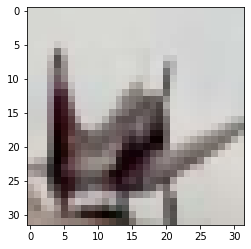

In [28]:
from matplotlib.pyplot import imshow
import numpy as np

%matplotlib inline
imshow(np.asarray(plane))

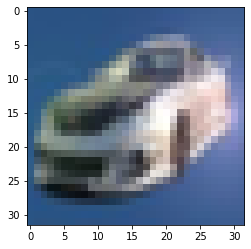

In [29]:
imshow(np.asarray(auto))

In [30]:
tplane = tensor(plane).float() / 255.
tauto = tensor(auto).float() / 255.

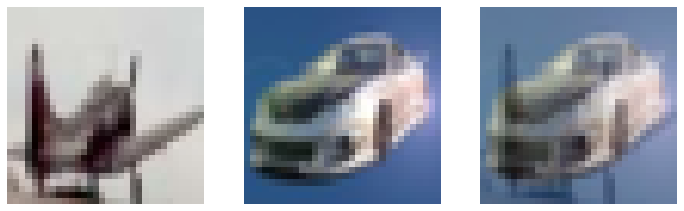

In [31]:
_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tplane, ax=axs[0]);
show_image(tauto, ax=axs[1]);
show_image((0.3*tplane + 0.7*tauto), ax=axs[2]);

In [7]:
model_2 = xresnet50()
learn = Learner(dls, model_2, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.879069,6.617074,0.213500,04:07
1,1.529116,1.128622,0.606333,04:06
2,1.357179,1.006156,0.655167,04:08
3,1.248913,0.779658,0.738333,04:08
4,1.175391,0.734723,0.756083,04:09


## Label Smoothing

### Label smothing help to generalize the model by smoothing out the labels. Whne the labels are strictly 1 and 0, the model strives for perfection and it leads overfitting. Whereas, when we smooth the labels to be little less than 1 like 0.95 and little more than 0 like 0.1, the model generalizes better

In [8]:
model_3 = xresnet50()
learn = Learner(dls, model_3, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.353574,3.771686,0.386917,04:08
1,2.014690,2.177841,0.565333,04:09
2,1.801432,1.718525,0.724083,04:08
3,1.626714,1.600100,0.773750,04:08
4,1.583770,1.567165,0.787083,04:08
